In [5]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, OrdinalEncoder, LabelEncoder, MinMaxScaler,PowerTransformer
import umap
from kmodes.kprototypes import KPrototypes
from sklearn.manifold import TSNE

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [ ]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, OrdinalEncoder, LabelEncoder, MinMaxScaler,PowerTransformer
import umap
from kmodes.kprototypes import KPrototypes
from sklearn.manifold import TSNE

In [6]:

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans, AgglomerativeClustering, dbscan
import scipy.cluster.hierarchy as shc
import plotly.graph_objs as go
from sklearn.neighbors import NearestNeighbors


# Présentation du projet

Bonjour, 

Pour des raisons de confidentialité, nous ne pouvons pas vous fournir beaucoup de données à ce stade. Ensuite, en raison de ressources limitées, nous avons dû vous fournir l’ensemble des données, alors que seule une partie va vous intéresser. Nos dashboards internes nous indiquent en effet que seuls 3 % des clients du fichier de données partagé avec vous ont réalisé plusieurs commandes.

Nous sommes confiants sur le fait que les données à disposition suffiront pour réaliser un premier clustering. Cela a déjà été fait par d’autres prestataires par le passé, avec encore moins de données.

La segmentation proposée doit être exploitable et facile d’utilisation par notre équipe Marketing. Elle doit au minimum pouvoir différencier les bons et moins bons clients en termes de commandes et de satisfaction. Nous attendons bien sûr une segmentation sur l’ensemble des clients.

Dans un deuxième temps, une fois le modèle de segmentation choisi, nous souhaiterions  que vous nous fassiez une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance.

Pour information, le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

Bien à vous,

Juan, de l’équipe Marketing

On charge les Dataframes

In [ ]:
customer_order = pd.read_csv("olist_customers_dataset.csv")

order = pd.read_csv("olist_orders_dataset.csv",
                       parse_dates=[
                           "order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date",
                           "order_delivered_customer_date", "order_estimated_delivery_date"
                       ])

order_items = pd.read_csv("olist_order_items_dataset.csv",
                             parse_dates=["shipping_limit_date"])

order_reviews=pd.read_csv("olist_order_reviews_dataset.csv")

payments = pd.read_csv("olist_order_payments_dataset.csv")

products = pd.read_csv("olist_products_dataset.csv")

sellers = pd.read_csv("olist_sellers_dataset.csv")

product_category = pd.read_csv("product_category_name_translation.csv")

geolocation=pd.read_csv("olist_geolocation_dataset.csv")

In [ ]:
files=[customer_order,order_items,order,order_reviews,payments,products,sellers,product_category,geolocation]

On va regarder la composition de nos Dataframes puis les merge en suivant le graphique :

In [5]:
for df in files:
    display(df.head())

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


Il y a un probleme avec le clé zip_code de géolocalistion, on ne tiendra pas compte de ce DataFrame pour la suite

In [6]:
len(customer_order['customer_zip_code_prefix'].sort_values().unique().tolist())

14994

In [7]:
len(sellers['seller_zip_code_prefix'].sort_values().unique().tolist())

2246

In [8]:
len(geolocation['geolocation_zip_code_prefix'].sort_values().unique())

19015

In [9]:
for df in files:
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


None

In [10]:
#Merge les Dataframe 1 a 1 jusqu'a obtenir le Dataframe Merged
temp_order = customer_order.merge(order, on=["customer_id"], how="inner")
temp_product = temp_order.merge(order_items, on=["order_id"], how="inner")
temp_payments = temp_product.merge(payments, on=["order_id"], how="inner")
temp_products = temp_payments.merge(products, on=["product_id"], how="inner")
temp_sellers = temp_products.merge(sellers, on=["seller_id"], how="inner")
temp_review=temp_sellers.merge(order_reviews, on=["order_id"], how="inner")
merged = temp_review.merge(product_category, on=["product_category_name"], how="inner")

In [11]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    115609 non-null  object        
 1   customer_unique_id             115609 non-null  object        
 2   customer_zip_code_prefix       115609 non-null  int64         
 3   customer_city                  115609 non-null  object        
 4   customer_state                 115609 non-null  object        
 5   order_id                       115609 non-null  object        
 6   order_status                   115609 non-null  object        
 7   order_purchase_timestamp       115609 non-null  datetime64[ns]
 8   order_approved_at              115595 non-null  datetime64[ns]
 9   order_delivered_carrier_date   114414 non-null  datetime64[ns]
 10  order_delivered_customer_date  113209 non-null  datetime64[ns]
 11  

In [12]:
merged.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_id',
       'review_score', 'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name_english'],
      dtype='object')

On enleve les colonnes n'apportant pas d'informations utiles

In [13]:
to_drop_review=['review_creation_date','review_answer_timestamp','review_id','review_comment_message','review_id']
to_drop_seller=['seller_zip_code_prefix','seller_city','seller_state','seller_id']
to_drop_order=['order_item_id','product_id','price','order_approved_at','order_id',
               'order_delivered_carrier_date','order_estimated_delivery_date']
to_drop_customer=['customer_unique_id','customer_zip_code_prefix']
to_drop_product=['product_length_cm','product_height_cm','product_width_cm','product_weight_g',
                 'product_photos_qty','product_description_lenght','product_name_lenght','product_category_name',
                 'product_name_lenght','payment_type','payment_installments','payment_sequential']
to_drop=to_drop_product+to_drop_seller+to_drop_review+to_drop_order+to_drop_customer
merged=merged.drop(to_drop,1)

C:\Users\pon\AppData\Local\Temp\ipykernel_16424\1577202336.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  merged=merged.drop(to_drop,1)


In [14]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    115609 non-null  object        
 1   customer_city                  115609 non-null  object        
 2   customer_state                 115609 non-null  object        
 3   order_status                   115609 non-null  object        
 4   order_purchase_timestamp       115609 non-null  datetime64[ns]
 5   order_delivered_customer_date  113209 non-null  datetime64[ns]
 6   shipping_limit_date            115609 non-null  datetime64[ns]
 7   freight_value                  115609 non-null  float64       
 8   payment_value                  115609 non-null  float64       
 9   review_score                   115609 non-null  int64         
 10  review_comment_title           13801 non-null   object        
 11  

Création d'une variable 'temps de livraison'

In [15]:
merged['delivery_time']=merged['order_delivered_customer_date']-merged['order_purchase_timestamp']
merged=merged.drop('order_delivered_customer_date',1)

C:\Users\pon\AppData\Local\Temp\ipykernel_16424\2158380206.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  merged=merged.drop('order_delivered_customer_date',1)


In [16]:
#convertion en int
merged['delivery_time']=merged['delivery_time'].astype('timedelta64[D]')
merged=merged.dropna(subset=['delivery_time'])
merged['delivery_time']=merged['delivery_time'].astype(int)

Modification du la variable 'review_comment_title':
-La valeur sera 1 si il y a eu un commentaire , 0 sinon.

In [17]:
merged['review_comment_title']=merged['review_comment_title'].fillna(0)
merged['review_comment_title']=merged['review_comment_title'].map(lambda v: 0 if v==0 else 1)


# Analyse Univariée

On va analyser les répartitions des différentes variables numériques et catégorielles

<AxesSubplot:title={'center':'Nombre de commande par clients'}>

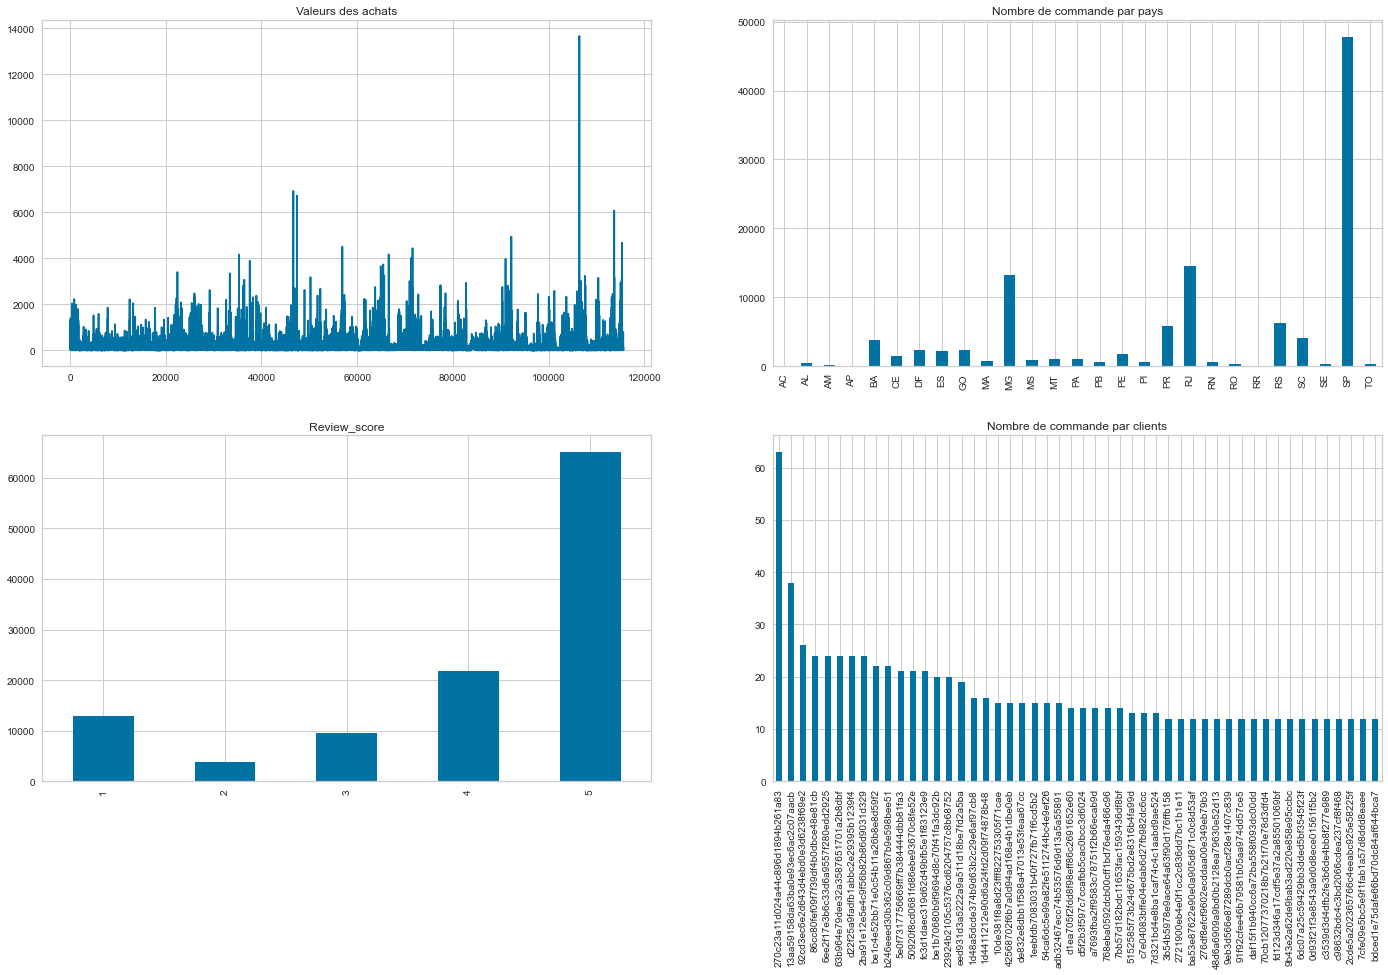

In [18]:
fig = plt.figure(figsize=(24,14))

axes = plt.subplot2grid((2,2),(0,0))
merged["payment_value"].plot(title='Valeurs des achats', ax=axes)

axes = plt.subplot2grid((2,2),(0,1))
merged["customer_state"].value_counts().sort_index(axis=0).plot.\
bar(title='Nombre de commande par pays',ax=axes)

axes = plt.subplot2grid((2,2),(1,0))
merged["review_score"].value_counts().sort_index(axis=0).plot.\
bar(title='Review_score',ax=axes)

axes = plt.subplot2grid((2,2),(1,1))
merged["customer_id"].value_counts().sort_values(ascending=False).head(50).plot.\
bar(title='Nombre de commande par clients',ax=axes)

<AxesSubplot:title={'center':'Nombre de commande par clients'}>

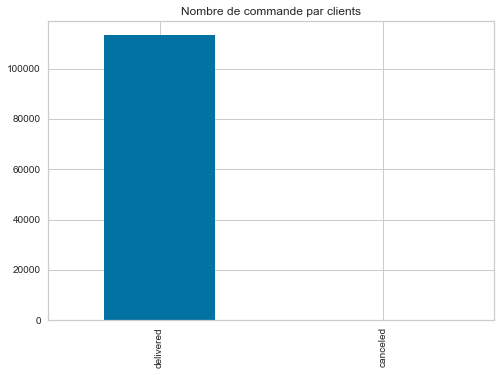

In [19]:
merged["order_status"].value_counts().sort_values(ascending=False).head(50).plot.\
bar(title='Nombre de commande par clients')

Le nombre de commandes non livrées étant très faible , on va se concentrer uniquement sur les commandes livrées

In [20]:
merged=merged[merged["order_status"]=='delivered'].copy()
merged.drop("order_status",1,inplace=True)

C:\Users\pon\AppData\Local\Temp\ipykernel_16424\4144389068.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  merged.drop("order_status",1,inplace=True)


In [21]:
merged["month"]=merged['order_purchase_timestamp'].dt.month
merged["day"]=merged['order_purchase_timestamp'].dt.dayofweek

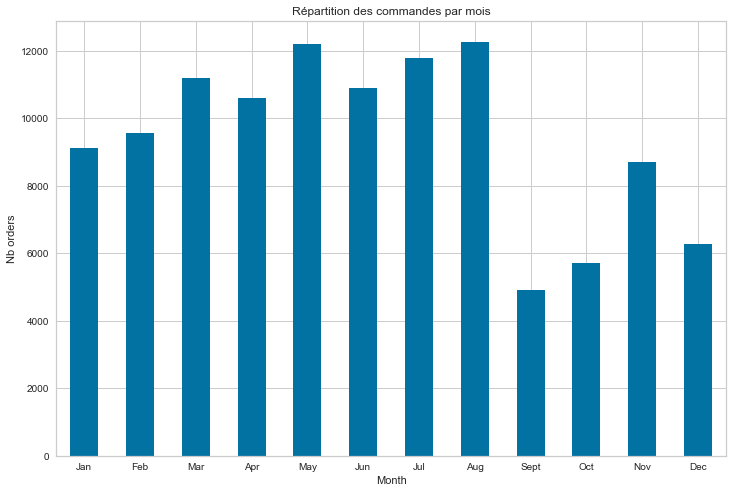

In [22]:
merged.groupby('month')\
    .count()['customer_id']\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par mois",
          ylabel="Nb orders",
          xlabel="Month",
          legend=False)
plt.xticks(np.arange(0,12), ['Jan','Feb','Mar','Apr','May','Jun',
                             'Jul','Aug','Sept','Oct','Nov','Dec'], 
           rotation='horizontal')
plt.show()

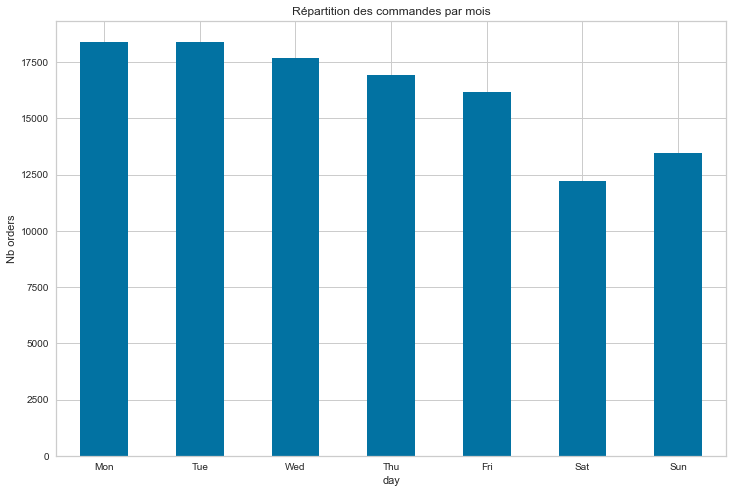

In [23]:
merged.groupby('day')\
    .count()['customer_id']\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par mois",
          ylabel="Nb orders",
          xlabel="day",
          legend=False)
plt.xticks(np.arange(0,7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], 
           rotation='horizontal')
plt.show()

# Preprocessing

Pour effectuer une segmentation des clients , nous allons avoir besoin d'un DataFrame ne listant pas des transaction mais des clients , pour cela nous allons effectuer un peu de preprocessing.


Dans un premier temps nous allons créer de variable RFM (Recency,Frequency et Monetary)

In [24]:
#Création du dataframe recency
merged_recency = merged.groupby(by='customer_id',
                        as_index=False)['order_purchase_timestamp'].max()
merged_recency.columns = ['customer_id', 'LastPurchaseDate']
recent_date = merged_recency['LastPurchaseDate'].max()
merged_recency['Recency'] = merged_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
merged_recency.head()

,customer_id,LastPurchaseDate,Recency
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,287
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,409
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,547
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,378
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,149


In [25]:
#Création du dataframe frequency
frequency_merged = merged.drop_duplicates().groupby(
    by=['customer_id'], as_index=False)['order_purchase_timestamp'].count()
frequency_merged.columns = ['customer_id', 'Frequency']
frequency_merged.head()

,customer_id,Frequency
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1


In [26]:

#Création du dataframe 'monetary'
monetary_merged = merged.groupby(by='customer_id', as_index=False)['payment_value'].sum()
monetary_merged.columns = ['customer_id', 'Monetary']
monetary_merged.head()

,customer_id,Monetary
0,00012a2ce6f8dcda20d059ce98491703,114.74
1,000161a058600d5901f007fab4c27140,67.41
2,0001fd6190edaaf884bcaf3d49edf079,195.42
3,0002414f95344307404f0ace7a26f1d5,179.35
4,000379cdec625522490c315e70c7a9fb,107.01


In [27]:
#merge des Dataframe
rf_merged = merged_recency.merge(frequency_merged, on='customer_id')
rfm_merged = rf_merged.merge(monetary_merged, on='customer_id').drop(
    columns='LastPurchaseDate')
rfm_merged.head()

,customer_id,Recency,Frequency,Monetary
0,00012a2ce6f8dcda20d059ce98491703,287,1,114.74
1,000161a058600d5901f007fab4c27140,409,1,67.41
2,0001fd6190edaaf884bcaf3d49edf079,547,1,195.42
3,0002414f95344307404f0ace7a26f1d5,378,1,179.35
4,000379cdec625522490c315e70c7a9fb,149,1,107.01


Pour le reste du preprocessing on va faire un agrégat du Dataframe initial selon les méthodes suivantes :
- mean pour les variables review_score,elivery_time
- max pour la variable review_comment_title (La variable vaudra 1 si le client a commenter au moin une fois)
- mode pour les variables "customer_state","day","month","product_category_name_english"

In [28]:
temp=merged.groupby("customer_id")\
        .agg({"review_score" : "mean",
             "delivery_time" : 'mean',
             "review_comment_title": "max",
              "customer_state": lambda x:x.mode(),
             "day": lambda x:x.mode(),
             "month": lambda x:x.mode(),
             "product_category_name_english": lambda x:x.mode().explode()})

rfm_merged=rfm_merged.merge(temp, on=["customer_id"], how="inner")

In [29]:
rfm_merged['product_category_name_english']=rfm_merged['product_category_name_english'].map(
    lambda cat : cat if isinstance(cat,str) else cat[0])

# Analyse Univariée

Affichage dee la répartition des variables Recency , Frequency et Monetary

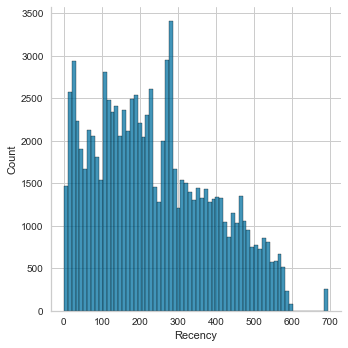

In [30]:

sns.displot(rfm_merged['Recency'])

C:\Users\pon\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Frequency', ylabel='Density'>

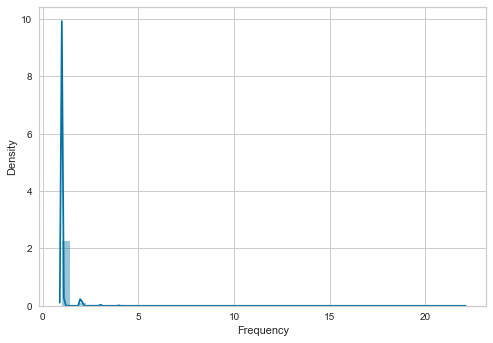

In [31]:
sns.distplot(rfm_merged['Frequency'])

In [32]:
rfm_merged.groupby('Frequency').count()['customer_id']

Frequency
1     89445
2      4393
3       397
4       154
5        16
6        26
7        12
8         7
9         6
10        4
11        7
12        5
14        1
16        1
17        2
19        1
20        2
22        1
Name: customer_id, dtype: int64

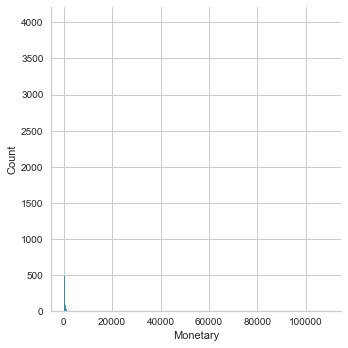

In [33]:
sns.displot(rfm_merged['Monetary'])

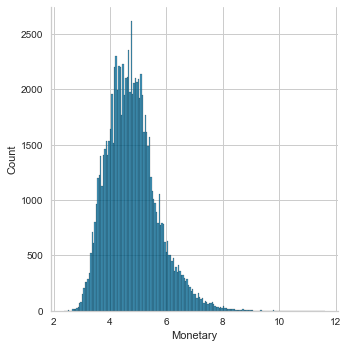

In [34]:
rfm_merged['Monetary']=np.log(rfm_merged['Monetary']+1)
sns.displot(rfm_merged['Monetary'])


displot des pays et temps de livraison

# Analyse multivariée

on verifie la si des donnèes manquent

<AxesSubplot:>

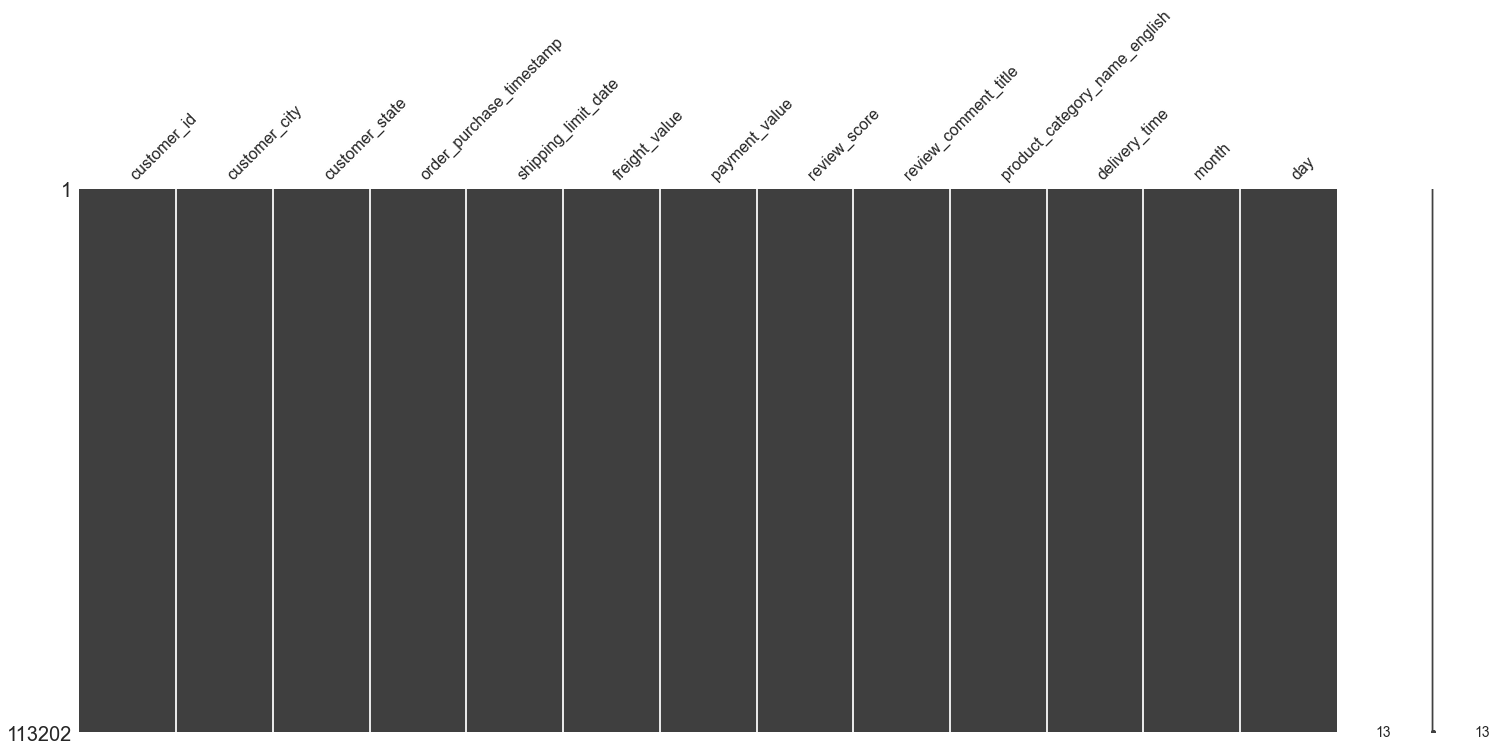

In [35]:
msno.matrix(merged)

In [36]:
categorial=['customer_state','review_score','review_comment_title','product_category_name_english','day','month']

In [37]:
merged.drop('customer_city',1,inplace=True)

C:\Users\pon\AppData\Local\Temp\ipykernel_16424\3288892482.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  merged.drop('customer_city',1,inplace=True)


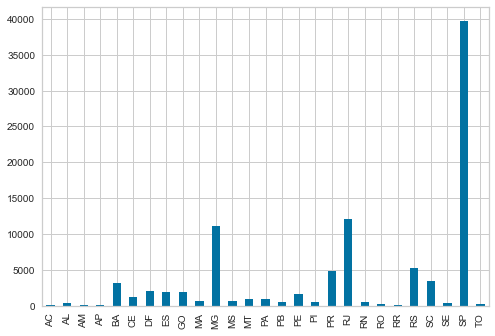

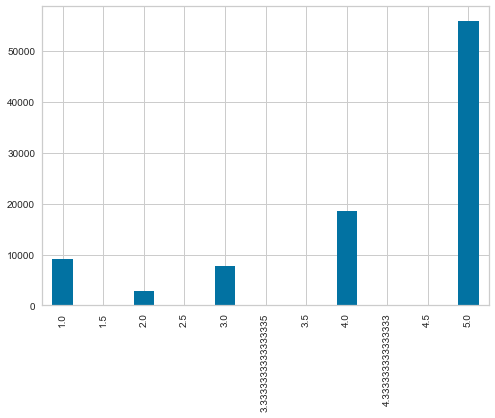

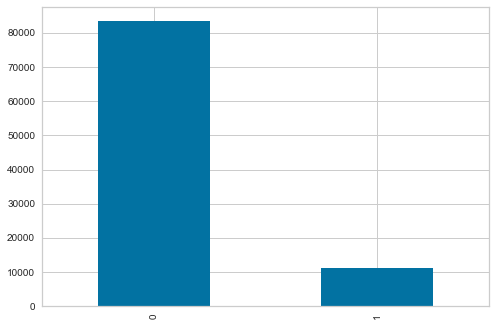

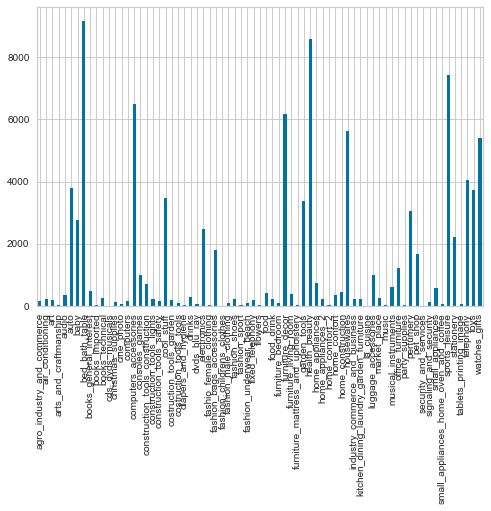

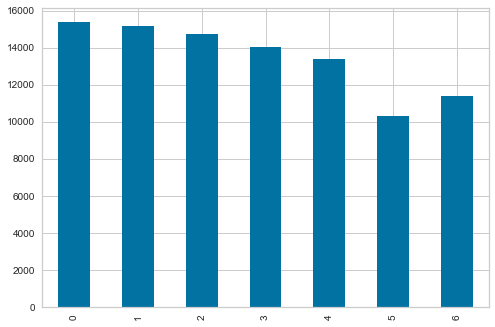

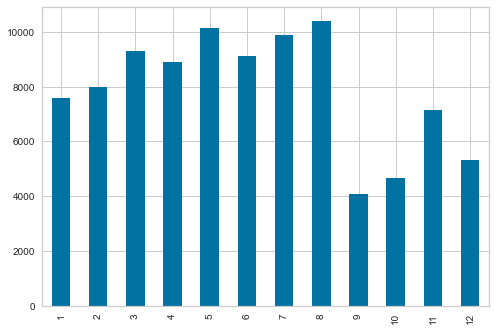

In [38]:
for cat in categorial:    
    rfm_merged[cat].value_counts().sort_index(axis=0).plot(kind='bar')
    plt.show()

C:\Users\pon\AppData\Local\Temp\ipykernel_16424\389115480.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticks(), rotation = 90)
C:\Users\pon\AppData\Local\Temp\ipykernel_16424\389115480.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticks(), rotation = 90)
C:\Users\pon\AppData\Local\Temp\ipykernel_16424\389115480.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(axs[2].get_xticks(), rotation = 90)
C:\Users\pon\AppData\Local\Temp\ipykernel_16424\389115480.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticks(), rotation = 90)
C:\Users\pon\AppData\Local\Temp\ipykernel_16424\389115480.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticks(), rotation = 90)


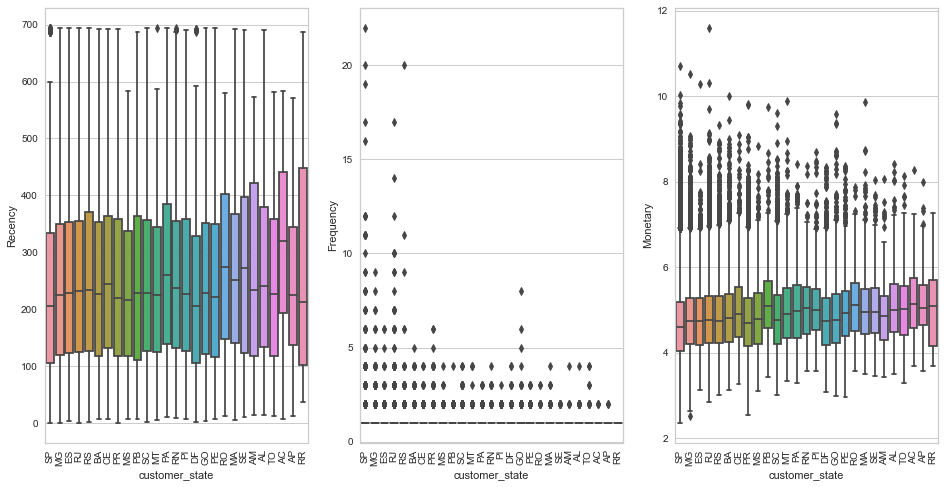

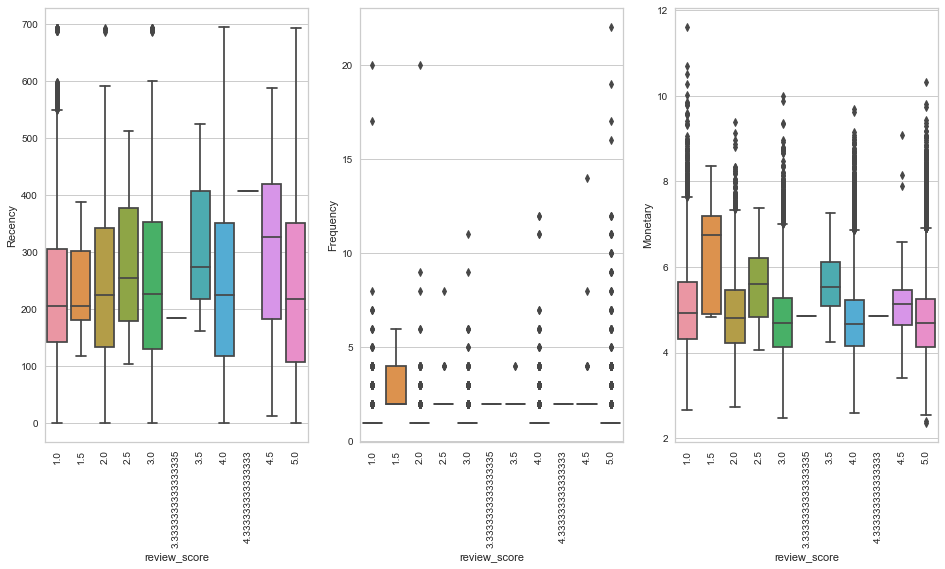

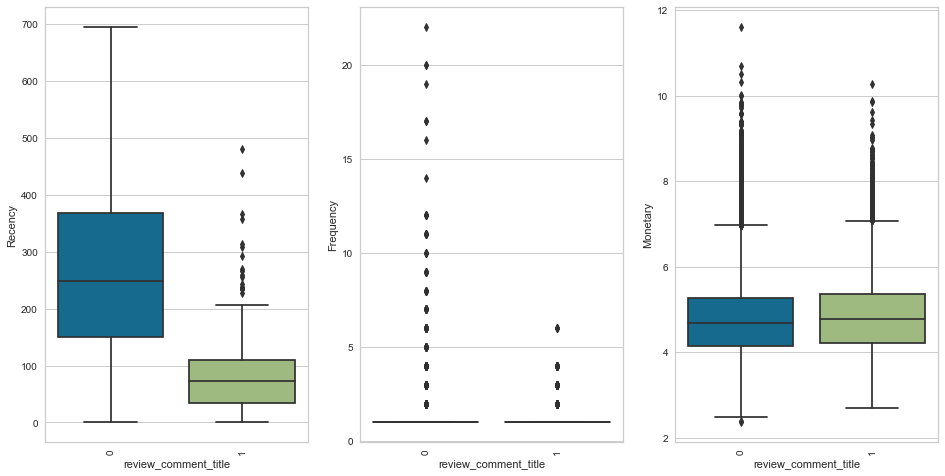

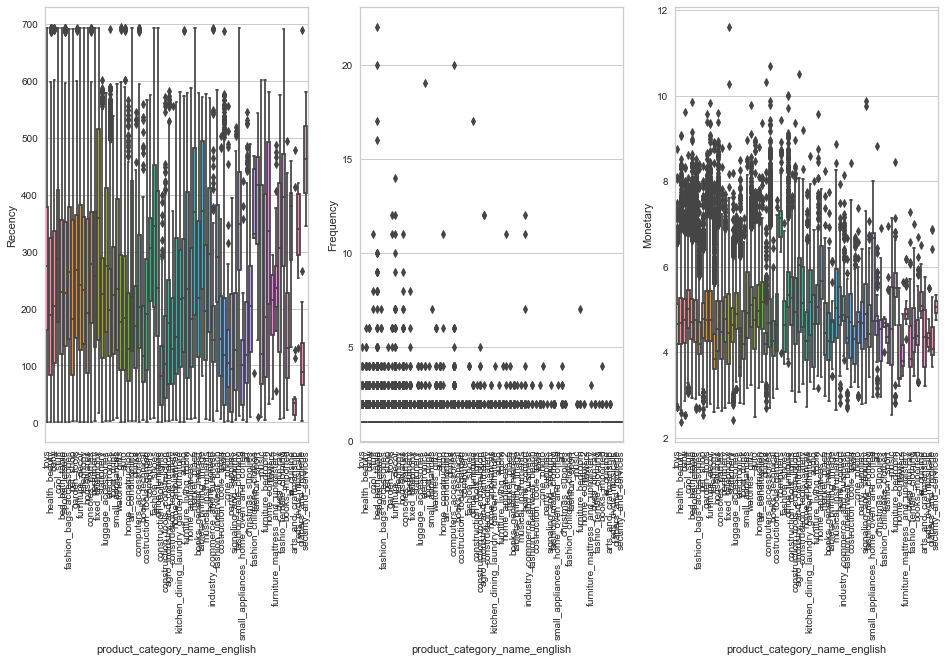

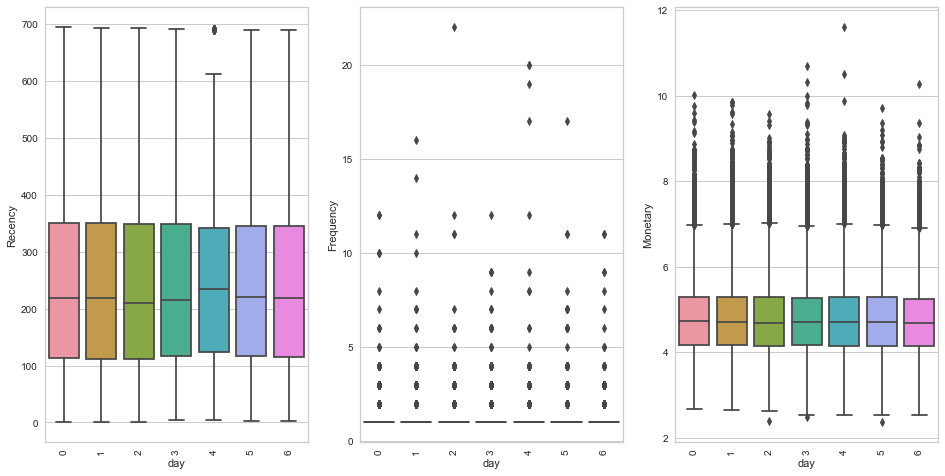

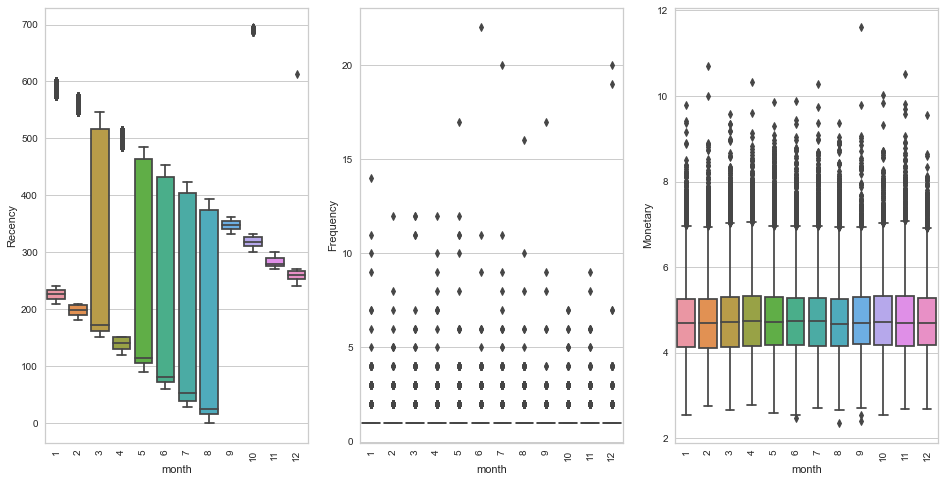

In [39]:
for cat in categorial:
    fig, axs = plt.subplots(1,3,figsize=(16,8))
    axs[0].set_xticklabels(axs[0].get_xticks(), rotation = 90)
    axs[1].set_xticklabels(axs[1].get_xticks(), rotation = 90)
    axs[2].set_xticklabels(axs[2].get_xticks(), rotation = 90)
    sns.boxplot(x=cat,y='Recency',data=rfm_merged,ax=axs[0])
    sns.boxplot(x=cat,y='Frequency',data=rfm_merged,ax=axs[1])
    sns.boxplot(x=cat,y='Monetary',data=rfm_merged,ax=axs[2])

On va regarder l'impact monétaire de chaque catégorie de produit

<AxesSubplot:title={'center':'Average Revenue (R$) per Sale per Category'}, xlabel='product_category_name_english'>

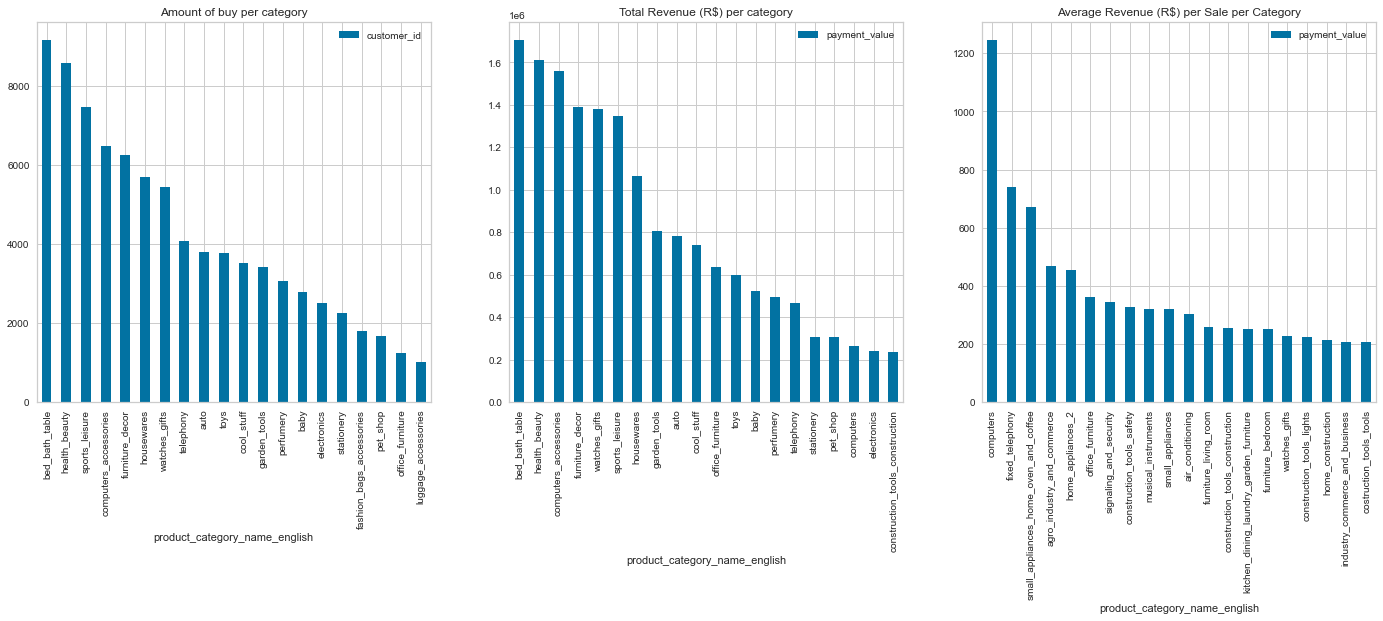

In [40]:
fig = plt.figure(figsize=(24,7))

axes = plt.subplot2grid((1,3),(0,0))
merged.groupby("product_category_name_english").agg({"customer_id": "nunique"})\
.sort_values('customer_id', ascending=False).head(20).plot.\
bar(title='Amount of buy per category', ax=axes)

axes = plt.subplot2grid((1,3),(0,1))
merged.groupby("product_category_name_english").agg({"payment_value": "sum"})\
.sort_values('payment_value', ascending=False).head(20).plot.\
bar(title='Total Revenue (R$) per category',ax=axes)

axes = plt.subplot2grid((1,3),(0,2))
merged.groupby("product_category_name_english").agg({"payment_value": "mean"})\
.sort_values('payment_value', ascending=False).head(20).plot.\
bar(title='Average Revenue (R$) per Sale per Category',ax=axes)

<AxesSubplot:>

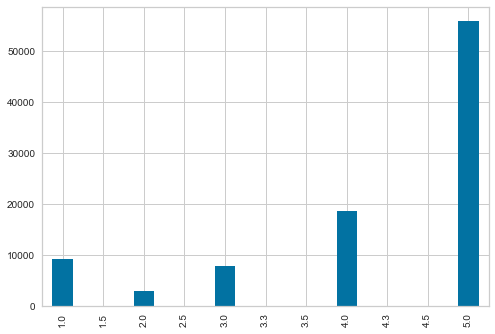

In [41]:
rfm_merged["review_score"]=rfm_merged["review_score"].round(1)
rfm_merged["review_score"].value_counts().sort_index(axis=0).plot(kind='bar')

On verifie si nos variables numériques ne sont pas trop corrélés en utilisant une Heatmap

Text(0.5, 1.0, 'Corrélation entre les variables numériques')

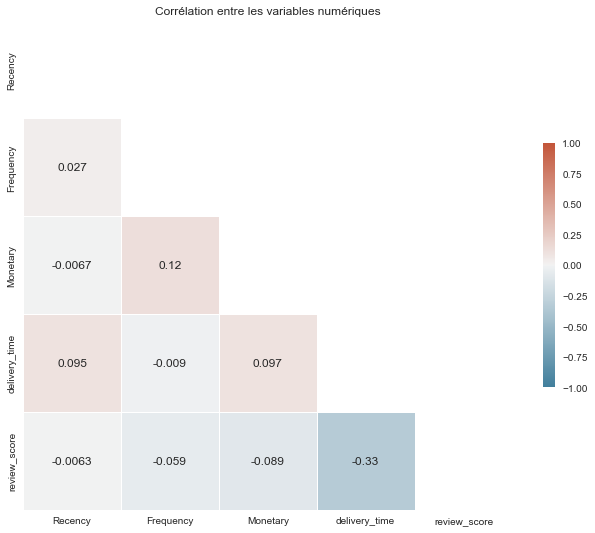

In [42]:
num=['Recency','Frequency','Monetary','delivery_time','review_score']
corr = rfm_merged[num].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=(-1), center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.title('Corrélation entre les variables numériques')

In [88]:
rfm_merged.to_csv('clean.csv',sep='\t',index=False)
merged.to_csv('merged_clean.csv',sep='\t',index=False)